In [3]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *
import anndata as ad
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

## Loading RF Models & Datasets

Paths to pericellular/other patterns RF models

In [4]:
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular.pkl"
with open(path1, 'rb') as p:
    rf_pericellular_splitID_balanced = pickle.load(p)

# The plots from the ppt are from this unbalanced model, didn't have the time to make a balanced version yet.
path2 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/incl_random/rf_pericellular.pkl"
with open(path2, 'rb') as p:
    rf_pericellular_inclRandom_splitID_unbalanced = pickle.load(p)

path3 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular_balanced_mixedIDs.pkl"
with open(path3, 'rb') as p:
    rf_pericellular_mixedID_balanced = pickle.load(p)

Here's the paths to load the pattern/no pattern RF (balanced & unbalanced) in case you would like them:

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_pattern_noPattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_unbalanced = pickle.load(p)

In [5]:
adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [6]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['strong', 'intermediate', 'low']
for adata in [adata_split_cellID, adata_all_spots, adata_mixed_cellID]:
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [7]:
# Creating the simulated genes (1 gene ~300 cells). Method can be found in dataprep.py
# In this case, the genes contain all the counts, iso only low counts. 
pericellular_dict_all = subsetGenes(adata_all_spots, 'pericellular', pattern_strength = "strong", mixed_counts = True)
peri_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_cellID = subsetGenes(adata_split_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_testID = subsetGenes(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])], 'pericellular', pattern_strength = "strong", mixed_counts = True)

# Generating the Histograms

Based on the Dictionaries created above, this code snippet creates a dataframe with the RF classification probabilities of the different models for the different datasets. The histograms below include 10 of these genes, hence the range(10). 

Predict_proba returns a nx2 array, where the two columns are the probabilities for [other pattern, pattern], hence the [:,1]

In [8]:
rows = []
gene_id = np.array(range(10))
 
for model in [rf_pericellular_splitID_balanced, rf_pericellular_inclRandom_splitID_unbalanced,rf_pericellular_mixedID_balanced]:
    for i in range(10):
        all_spots = model.predict_proba(pericellular_dict_all.get(i).obsm["latent"])[:,1]
        mixed_cellID = model.predict_proba(peri_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
        split_testID = model.predict_proba(pericellular_dict_split_testID.get(i).obsm["latent"])[:,1]
        split_allID = model.predict_proba(pericellular_dict_split_cellID.get(i).obsm["latent"])[:,1]
        for value in all_spots:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'all_spots', 'gene_id': i})
        for value in mixed_cellID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_cellID', 'gene_id': i})
        for value in split_testID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'split_testID', 'gene_id': i})
        for value in split_allID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'split_allID', 'gene_id': i})
df = pd.DataFrame(rows)

Code below generates the histograms. You can easily change the model and dataset shown in the plot by changing the numbers in the third line.

67


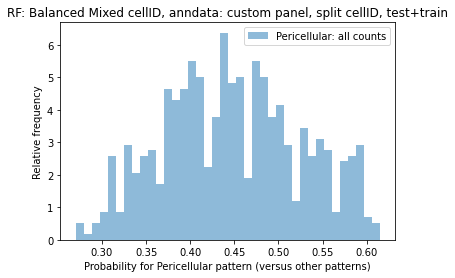

In [9]:
groups = ['all_spots','mixed_cellID','split_testID','split_allID']
models = [rf_pericellular_splitID_balanced, rf_pericellular_inclRandom_splitID_unbalanced,rf_pericellular_mixedID_balanced]
data = df[(df['group']==groups[2])&(df['model']==models[2])]

print(len(data['prob_pattern'].unique()))
plt.hist(data['prob_pattern'], bins=38, alpha=0.5, label='Pericellular: all counts', density=True)

plt.title("RF: Balanced Mixed cellID, anndata: custom panel, split cellID, test+train")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

# Code I used to generate the RF in case you're interested

## Preprocessing data

In [13]:
# Decided to use "no pattern" iso "random" for pattern versus no pattern classifier. 
adata_split_cellID.obs['random_or_pattern'] = adata_split_cellID.obs['random_or_pattern'].replace('random','no_pattern')
adata_split_cellID.obs['pattern'] = adata_split_cellID.obs['pattern'].replace('random','no_pattern')

In [14]:
adata_strong = adata_split_cellID[adata_split_cellID.obs['pattern_strength']=='strong']

adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

### Pattern / No pattern RF

In [17]:
# Balancing the training sets. 
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train, random_seed=seed)
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test, random_seed=seed)

I did hyperparameter tuning, and the best parameters I got were with `max_features=3` and `n_estimators=200`. 
Can share that if you want, but don't think it is very relevant here.

In [16]:
# create random forest classifier and fit on training data
rf_classifier_balanced = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_classifier_balanced.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

### RF: Pericellular versus other patterns 

In [18]:
# Add column to data to use for binary classifiers RF, eg. "pericellular" or "other". 
# Then balance the training and test set for the binary pattern/other patterns classifier.

patterns = adata_train[adata_train.obs['pattern']!='random'].obs['pattern'].unique()
train_data = {}
test_data = {}

for pattern in patterns:
    adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
    adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")
    train_data[pattern] = balanceTrainingData(adata_train, testPattern = pattern, include_random = False, random_seed = seed)
    test_data[pattern] = balanceTrainingData(adata_test, testPattern = pattern, include_random = False, random_seed = seed)


<ipython-input-18-fa1769cd0c7c>:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
<ipython-input-18-fa1769cd0c7c>:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")


f1 score:  0.9623204551784507
inverted f1 score:  0.9632218726940852
auc:  0.9949018150903575


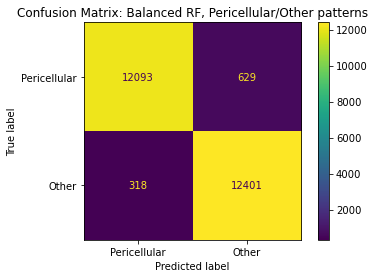

In [19]:
 # create random forest classifier Pericellular/Other patterns EXCLUDING random
rf_pericellular_splitID_balanced = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_pericellular_splitID_balanced.fit(train_data['pericellular'].obsm["latent"], train_data['pericellular'].obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular_splitID_balanced.predict(test_data['pericellular'].obsm["latent"]) # for f1 & confusion matrix
test_peri = rf_pericellular_splitID_balanced.predict_proba(test_data['pericellular'].obsm["latent"]) # for auc


print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='other'))
print("auc: ", roc_auc_score(test_data['pericellular'].obs["pericellular"], test_peri[:,1]))


confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular, labels = ["pericellular","other"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pericellular", "Other"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF, Pericellular/Other patterns")
plt.show()

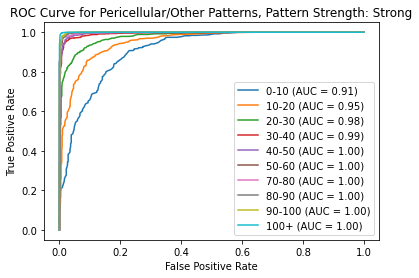

In [28]:
adata_test_peri_balanced = test_data['pericellular']
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_peri_balanced[adata_test_peri_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_pericellular_splitID_balanced.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['pericellular'],
        test_pred, 
        pos_label = "pericellular",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Pericellular/Other Patterns, Pattern Strength: Strong")
ax.plot(np.arange(0,1,5),np.arange(0,1,5))

plt.legend(loc='lower right')
plt.show()